# Experiment on the Math PhD Exchange

This data set comes from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha. What is tracked here is **not** hiring data. In each year, the authors scraped the number of PhDs produced at institution $j$ whose advisor received a PhD at institution $i$. This is arguably a proxy for hiring data, but there are several issues. For example, if a scholar is hired at institution $j$, they won't actually appear in this data set until their first PhD student graduates, which would presumably be 4-7 years after their hiring. 

Since our model is obviously mis-specified on this data, we should proceed with caution. 

In [32]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
import pandas as pd
%matplotlib inline

In [33]:
# the hiring data itself

df = pd.read_csv('data/PhD Exchange Network Data/PhD_exchange.txt', 
            delim_whitespace=True, 
            names = ('endorsed', 'endorser', 'k', 'year'))

with open('data/PhD Exchange Network Data/school_names.txt') as f:
    snames = f.read().splitlines()
# df[['endorsed', 'k']].groupby('endorsed').sum()

There are problems in the analysis when the hiring graph is disconnected. In this case, the SpringRanks on the two components are not comparable, and the model can do strange things. So, we are going to filter down to the top 70 departments by PhDs supervised. Sorry for the garbage code -- pandas is not my strong point. 

In [34]:
top_deps = df[['endorsed', 'k']].groupby('endorsed').sum().nlargest(70,'k') # 20 seemed to give reasonable results
top_deps = np.array(top_deps.index)
df = df[df['endorsed'].isin(top_deps)]
df = df[df['endorser'].isin(top_deps)]

lookup = {top_deps[i] : i + 1000 for i in range(len(top_deps))}
df = df.replace({'endorsed' : lookup, 'endorser' : lookup})
df.endorsed = df.endorsed - 1000
df.endorser = df.endorser - 1000

# associated names with indices in df
lookup = {lookup[key] - 1000 : snames[key-1] for key in lookup}

The next step is to transform the data into a sequence of cumulative hiring matrices. 

In [35]:
# primary data transformation: here be bugs??

n = max(df.endorser.max()+1, df.endorsed.max()+1)

t_min = df.year.min()

T_ = np.zeros((df.year.max() - df.year.min()+1, n, n))
for i in df.index:
    T_[df.year[i] - t_min, df.endorsed[i], df.endorser[i]] += df.k[i] 
T = np.cumsum(T_, axis = 0)

In order to set the initial condition, we'll start with 20 years of data and plug all that into the initial hiring matrix, then normalize. This is to help remove artifacts at the very beginning of the time-series. 

In [36]:
# Let's start t_start years in
t_start = 18

A0 = T[t_start,:,:]
A0 = A0 / A0.sum() # normalized

# mean hiring per year after t_start: 
v = T[t_start:,:,:].sum(axis = (1,2))
A0 = A0*((v[-1] - v[0]) / len(v))

Next, we'll try to learn the parameters from the data. 

In [37]:
lam_grid = 51 # resolution in $\lambda$
b_grid = 51   # resolution in $\beta$

LAMBDA = np.linspace(.5, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(1, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, LAMBDA, BETA, A0) 

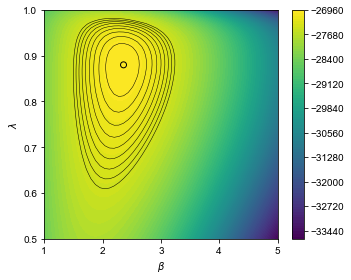

In [38]:
fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(111)

xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax.contourf(xg, yg, M, levels = 100)
ax.contour(xg, yg, M, 
           levels = np.linspace(M.max()-500, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

ax.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

plt.tight_layout()

In [39]:
# the estimates are: 
ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]
beta_hat, lambda_hat

(2.3600000000000003, 0.88)

# Time-Series Visualization

Now that we have plausible(??) values for $\lambda$ and $\beta$, we can visualize time-series of $\gamma$.

In [42]:
T_ = T[t_start:,:,:]

years = np.arange(df.year.min() + t_start, df.year.max()+1)
lam = lambda_hat
n_rounds = T_.shape[0]
beta = beta_hat

# def plot_gammas(T, lam, title = '', figsize = (5,4)):
A = estimation.state_matrix(T_, lam, A0) # check in on this state matrix computation, seems off
GAMMA = np.zeros((n_rounds, n))
for k in range(n_rounds):
    GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
top_trajectories = np.unique(GAMMA.argmax(axis = 1))
top_trajectories = (-GAMMA.mean(axis = 0)).argsort()[0:6]

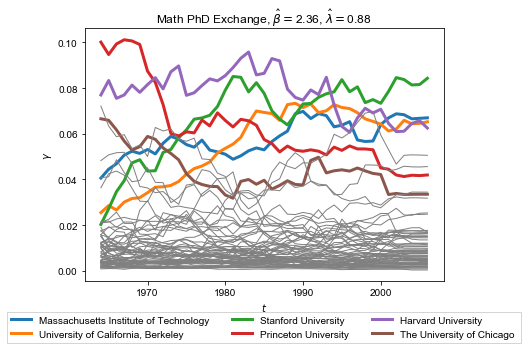

In [45]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)

k = 0
for l in range(n):
    if l in top_trajectories: 
        ax.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3, label = lookup[l])
        k += 1
    else:
        ax.plot(years, GAMMA[:,l], color = 'grey', alpha = 1, linewidth = 1)

        
    ax.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Math PhD Exchange, $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=3)

plt.tight_layout()

# A prettier version

The code below just takes these two plots and combines them into a single figure, with some cosmetics. 

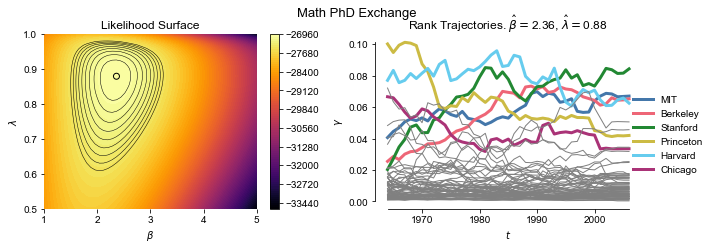

In [53]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"


fig = plt.figure(figsize = (10, 3.5))

ax1 = fig.add_subplot(121)
xg, yg = np.meshgrid(BETA, LAMBDA)

im = ax1.contourf(xg, yg, M, levels = 100, cmap = 'inferno')
ax1.contour(xg, yg, M, 
           levels = np.linspace(M.max()-500, 
                                M.max(), 10), 
           linewidths = .5, 
           colors = 'black', 
           linestyles = 'solid')

plt.colorbar(im)

#     ax.scatter(beta, lam, color = 'black')

ax1.set(xlabel = r'$\beta$',
       ylabel = r'$\lambda$',
       title = 'Likelihood Surface')

ix = np.where(M == M.max())
beta_hat = BETA[ix[1]][0]
lambda_hat = LAMBDA[ix[0]][0]

ax1.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')

for pos in ['top', 'right', 'left', 'bottom']: 
    ax1.spines[pos].set_visible(False)

ax2 = fig.add_subplot(122)

shortener = {
    'Massachusetts Institute of Technology ' : 'MIT',
    'University of California, Berkeley ' : 'Berkeley', 
    'Stanford University ' : 'Stanford',
    'Princeton University ' : 'Princeton',
    'Harvard University ' : 'Harvard',
    'Yale University ' : 'Yale',
    'The University of Chicago ' : 'Chicago'
}

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']



k = 0
for l in range(n):
    if l in top_trajectories: 
        ax2.plot(years, GAMMA[:,l], alpha = 1, linewidth = 3, label = shortener[lookup[l]], color = cset[k])
        k += 1
    else:
        ax2.plot(years, GAMMA[:,l], color = 'grey', alpha = 1, linewidth = 1)
        
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_bounds(0, GAMMA.max())
ax2.spines['bottom'].set_bounds(years.min(), years.max())

ax2.set(xlabel = r'$t$',
       ylabel = r'$\gamma$', 
       title = r'Rank Trajectories. $\hat{\beta} = $' + str(round(beta_hat, 2)) + r', $\hat{\lambda} = $' + str(round(lambda_hat, 2)))

ax2.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7),
          fancybox=False, shadow=False, ncol=1, frameon = False)

fig.suptitle('Math PhD Exchange', fontsize = 13)

plt.savefig('fig/math_phd_exchange.png', dpi = 300)

plt.tight_layout()